In [1]:
# Install necessary packages
!pip install tensorflow
!pip install kaggle
!pip install opencv-python
!pip install tensorflow-object-detection-api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.4/577.4 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.9 MB/s eta 0:00:00
  Created wheel for tensorflow-object-detection-api: filename=tensorflow_object_detection_api-0.1.1-py3-none-any.whl size=844486 sha256=44dd9646888bbeb2dd9d48596499376cc23776cd5a5063a75f27ecc0001b0b7f
  Stored in directory: /root/.cache/pip/wheels/8a/55/68/c084bc2cd93c41fd8f7e2ef9e6bbcb2c35a3e4b49e42044d02
Successfully built tensorflow-object-detection-api


# New Section

In [2]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.builders import post_processing_builder
from object_detection.builders import preprocessor_builder
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import config_util
from object_detection.utils import visualization_utils

# Import necessary libraries
import json
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split  # Add this import



# Save Kaggle API credentials as a JSON file
kaggle_api = {
    "username": "rihaahuja",
    "key": "3dbb7f364e9ac851b7a3e353d8a577a6"
}

with open('kaggle.json', 'w') as f:
    json.dump(kaggle_api, f)

# Create a directory for Kaggle credentials and move the JSON file
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set appropriate permissions for the Kaggle API credentials file
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle
!kaggle datasets download -d trainingdatapro/cars-video-object-tracking

# Unzip the downloaded dataset
!unzip cars-video-object-tracking.zip -d dataset




 99% 1.66G/1.67G [00:20<00:00, 57.9MB/s]
100% 1.67G/1.67G [00:20<00:00, 88.0MB/s]
Archive:  cars-video-object-tracking.zip
  inflating: dataset/annotations.xml  
  inflating: dataset/boxes/frame_000000.PNG  
  inflating: dataset/boxes/frame_000001.PNG  
  inflating: dataset/boxes/frame_000002.PNG  
  inflating: dataset/boxes/frame_000003.PNG  
  inflating: dataset/boxes/frame_000004.PNG  
  inflating: dataset/boxes/frame_000005.PNG  
  inflating: dataset/boxes/frame_000006.PNG  
  inflating: dataset/boxes/frame_000007.PNG  
  inflating: dataset/boxes/frame_000008.PNG  
  inflating: dataset/boxes/frame_000009.PNG  
  inflating: dataset/boxes/frame_000010.PNG  
  inflating: dataset/boxes/frame_000011.PNG  
  inflating: dataset/boxes/frame_000012.PNG  
  inflating: dataset/boxes/frame_000013.PNG  
  inflating: dataset/boxes/frame_000014.PNG  
  inflating: dataset/boxes/frame_000015.PNG  
  inflating: dataset/boxes/frame_000016.PNG  
  inflating: dataset/boxes/frame_000017.PNG  
  inflatin

# New Section

Perfoming the Exploratory Data Analysis (EDA)

Object category distribution:
car: 9432 objects
minivan: 241 objects


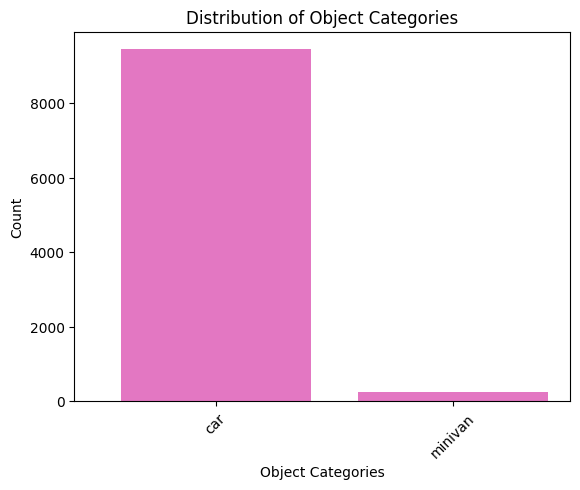

In [12]:
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

# This line is important for Colab to display the plots
%matplotlib inline

# Define the path to the annotations.xml file
annotations_file = 'dataset/annotations.xml'  # Modify this path if needed

# Initialize data structures to store EDA results
category_counts = {}

# Parse the XML file
tree = ET.parse(annotations_file)
root = tree.getroot()

# Extract object categories and update their counts
for track in root.iter('track'):
    label = track.get('label')
    for box in track.iter('box'):
        category = label  # You can modify this based on your dataset structure
        if category in category_counts:
            category_counts[category] += 1
        else:
            category_counts[category] = 1

# Display EDA results
print("Object category distribution:")
for category, count in category_counts.items():
    print(f"{category}: {count} objects")

# Generate and display a bar graph
categories = list(category_counts.keys())
counts = list(category_counts.values())

plt.bar(categories, counts)
plt.xlabel('Object Categories')
plt.ylabel('Count')
plt.xticks(rotation=45, fontsize=10)  # Rotate x-axis labels for better readability
plt.title('Distribution of Object Categories')
plt.show()


In [13]:
import xml.etree.ElementTree as ET
import pandas as pd

# Define the path to the annotations.xml file
annotations_file = 'dataset/annotations.xml'  # Modify this path if needed

# Initialize lists to store data
frames = []
x_positions = []
y_positions = []

# Parse the XML file
tree = ET.parse(annotations_file)
root = tree.getroot()

# Iterate through the tracks to extract x and y positions
for track in root.iter('track'):
    label = track.get('label')
    for box in track.iter('box'):
        frame = int(box.get('frame'))
        xtl = float(box.get('xtl'))
        ytl = float(box.get('ytl'))
        xbr = float(box.get('xbr'))
        ybr = float(box.get('ybr'))

        # Calculate x and y positions
        x = (xtl + xbr) / 2
        y = (ytl + ybr) / 2

        frames.append(frame)
        x_positions.append(x)
        y_positions.append(y)

# Create a DataFrame for the data
data = pd.DataFrame({'Frame': frames, 'X_Position': x_positions, 'Y_Position': y_positions})

# Display the first few rows of the data
print(data.head())


   Frame  X_Position  Y_Position
0     27     605.405       6.040
1     28     605.595       6.540
2     29     605.780       7.045
3     30     605.965       7.550
4     31     606.205       8.095


In [22]:
# Separate features (X) and target variables (y)
X = data[['Frame']]
y = data[['X_Position', 'Y_Position']]


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape (X, y):", X_train.shape, y_train.shape)
print("Testing data shape (X, y):", X_test.shape, y_test.shape)


Training data shape (X, y): (7738, 1) (7738, 2)
Testing data shape (X, y): (1935, 1) (1935, 2)


Epoch 1/50
194/194 [==============================] - 5s 12ms/step - loss: 112256.3906 - val_loss: 92337.8828
Epoch 2/50
194/194 [==============================] - 1s 6ms/step - loss: 92894.4219 - val_loss: 92048.8438
Epoch 3/50
194/194 [==============================] - 0s 2ms/step - loss: 92497.8984 - val_loss: 91653.2188
Epoch 4/50
194/194 [==============================] - 1s 3ms/step - loss: 92228.3828 - val_loss: 91495.3672
Epoch 5/50
194/194 [==============================] - 1s 3ms/step - loss: 91740.2969 - val_loss: 90863.9141
Epoch 6/50
194/194 [==============================] - 0s 2ms/step - loss: 91308.8516 - val_loss: 90359.3594
Epoch 7/50
194/194 [==============================] - 0s 2ms/step - loss: 90677.5391 - val_loss: 89632.6172
Epoch 8/50
194/194 [==============================] - 0s 2ms/step - loss: 89453.0703 - val_loss: 89324.7344
Epoch 9/50
194/194 [==============================] - 1s 3ms/step - loss: 87800.3906 - val_loss: 85785.1406
Epoch 10/50
194/194 [=====

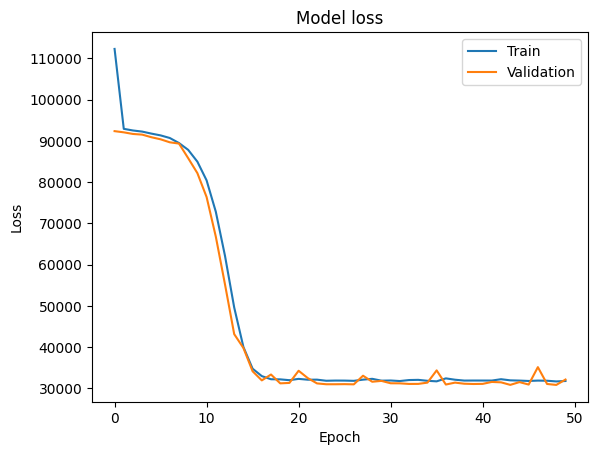

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(64, input_dim=1, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2))  # 2 output neurons for X and Y positions

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Define early stopping to monitor validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Print training history
import matplotlib.pyplot as plt

# This line is important for Colab to display the plots
%matplotlib inline

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [10]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Step 1: Load and preprocess data from annotations.xml
annotations_file = 'dataset/annotations.xml'  # Modify this path if needed
frames = []
x_positions = []
y_positions = []

tree = ET.parse(annotations_file)
root = tree.getroot()

for track in root.iter('track'):
    label = track.get('label')
    for box in track.iter('box'):
        frame = int(box.get('frame'))
        xtl = float(box.get('xtl'))
        ytl = float(box.get('ytl'))
        xbr = float(box.get('xbr'))
        ybr = float(box.get('ybr'))
        x = (xtl + xbr) / 2
        y = (ytl + ybr) / 2
        frames.append(frame)
        x_positions.append(x)
        y_positions.append(y)

data = pd.DataFrame({'Frame': frames, 'X_Position': x_positions, 'Y_Position': y_positions})

# Step 2: Define Features and Target Variable
X = data['Frame'].values.reshape(-1, 1)
y = data[['X_Position', 'Y_Position']].values



# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define a CNN model
image_height, image_width, channels = 64, 64, 3

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam')

# Step 5: Generate synthetic image data for data augmentation

num_train_samples = len(X_train)
X_train_images = np.random.rand(num_train_samples, image_height, image_width, channels)

datagen = ImageDataGenerator(
   rotation_range=40,
   width_shift_range=0.2,
   height_shift_range=0.2,
   shear_range=0.2,
   zoom_range=0.2,
   horizontal_flip=True,
   fill_mode='nearest')

datagen.fit(X_train_images)

# Step 6: Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
history = model.fit(X_train_images, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])





Epoch 1/50
194/194 [==============================] - 38s 183ms/step - loss: 43797.8867 - val_loss: 31003.0098
Epoch 2/50
194/194 [==============================] - 35s 182ms/step - loss: 32025.7031 - val_loss: 31092.1738
Epoch 3/50
194/194 [==============================] - 36s 185ms/step - loss: 31890.7305 - val_loss: 30993.1914
Epoch 4/50
194/194 [==============================] - 37s 190ms/step - loss: 31905.9746 - val_loss: 31069.7949
Epoch 5/50
194/194 [==============================] - 37s 190ms/step - loss: 31954.9316 - val_loss: 31130.5293
Epoch 6/50
194/194 [==============================] - 35s 182ms/step - loss: 32173.0996 - val_loss: 32058.6172
Epoch 7/50
194/194 [==============================] - 38s 195ms/step - loss: 31809.5684 - val_loss: 31460.3984
Epoch 8/50
194/194 [==============================] - 35s 178ms/step - loss: 31773.4316 - val_loss: 31376.3672
Epoch 9/50
194/194 [==============================] - 38s 195ms/step - loss: 31923.6113 - val_loss: 32082.1992
E

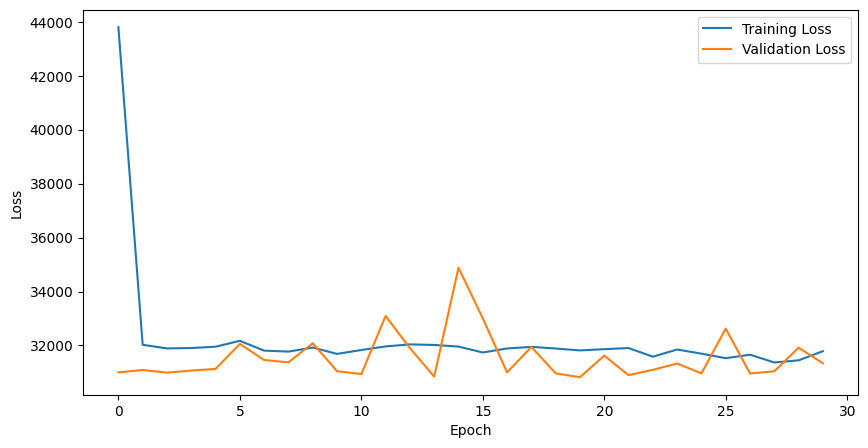

In [17]:


# Print training history
import matplotlib.pyplot as plt

# This line is important for Colab to display the plots
%matplotlib inline

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [18]:
model.save("object_tracking.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
from google.colab import files

# Get the path to the .h5 model file
file_path = '/content/object_tracking.h5'

# Download the file
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>